In [24]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sn
import matplotlib.pyplot as plt
import os
print(os.listdir("../input"))

#models and proccesing
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

['2017AllStarGame.csv', 'tabla_nba2018.csv', '2016AllStarGame.csv', 'tabla_nba2017.csv', '2018AllStarGame.csv', 'tabla_nba2016.csv']


In [2]:
# Players statistics from 2016-2018
data2016 = pd.read_csv("../input/tabla_nba2016.csv")
All2016 = pd.read_csv("../input/2016AllStarGame.csv", sep= ';')

data2017 = pd.read_csv("../input/tabla_nba2017.csv")
All2017 = pd.read_csv("../input/2017AllStarGame.csv", sep= ';')
# The players selection method changed after 2017.
data2018 = pd.read_csv("../input/tabla_nba2018.csv")
All2018 = pd.read_csv("../input/2018AllStarGame.csv", sep= ';')

In [3]:
#drop of duplicated and features that wont be used.
drops = ['Unnamed: 0','Ranking_x.1','Team_x.1','Games_y','Games_x.1','ReboundsxGame','Reboundsx48min',
         'MinutesxGame_x.1','TurnoversxGame_x', 'Assistsx48min','Ranking_y.1', 'Team_y.1', 'Games_y.1',
         'MinutesxGame_y.1','BlockxGame','Blockx48min', 'BlockxFoul', 'Ranking_x.2', 'Team_x.2', 
         'Games_x.2','MinutesxGame_x.2','StealsxGame', 'Stealsx48min','Turnovers_y', 'TurnoversxGame_y',
         'PersonalFouls_y','StealsxTurnover','StealsxFoul', 'Ranking_y.2', 'Team_y.2', 'Games_y.2',
         'MinutesxGame_y.2','PersonalFoulsxGame','PersonalFoulsx48min','Ranking_y','Team_y', 
         'MinutesxGame_y','FieldGoalsxGame','AssistsxGame','AssistxTurnover','PersonalFouls_x',
         'OffensiveReboundsxGame','DefensiveReboundsxGame', 'Ranking_x']

In [4]:
#preproccesing for each pair of datasets
def sepandrep(dataset,dataset2, droplist, year):
    
    dataset.drop(columns = droplist  ,inplace= True)
    
    divide = pd.DataFrame(dataset["Player"].str.split(',',expand=True))
    divide.columns=["Player","Position"]
    divide2 = pd.DataFrame(dataset["3Pointers"].str.split('-',expand=True))
    divide2.columns=["3Pointersmin","3Pointersmax"]
    divide3 = pd.DataFrame(dataset["FreeTrows"].str.split('-',expand=True))
    divide3.columns=["FreeTrowsmin","FreeTrowsmax"]

    dataset["Position"] = divide["Position"]
    dataset["Player"] = divide["Player"]
    dataset["3Pointersmin"] = divide2["3Pointersmin"].astype(float)
    dataset["3Pointersmax"] = divide2["3Pointersmax"].astype(float)
    dataset["FreeTrowsmin"] = divide3["FreeTrowsmin"].astype(float)
    dataset["FreeTrowsmax"] = divide3["FreeTrowsmax"].astype(float)
    
    dataset["3Pointers"] = (dataset["3Pointersmin"] + dataset["3Pointersmax"])/2
    dataset["FreeTrows"] = (dataset["FreeTrowsmin"] + dataset["FreeTrowsmax"])/2
    
    dataset.loc[dataset['Player'].isin(dataset2['Player']),'AllStars'] = 1
    dataset.loc[dataset['Player'].isin(dataset2['Player']) & dataset2['Starter'] == 1,'Starter'] = 1
    dataset.fillna(0, inplace= True)
    dataset['year'] = year

In [5]:
sepandrep(data2016, All2016, drops, 2016)
sepandrep(data2017, All2017, drops, 2017)
sepandrep(data2018, All2018, drops, 2018)

In [6]:
#Merge
data = pd.concat([data2016,data2017,data2018])
data.shape

(1368, 29)

In [7]:
data.columns

Index(['Player', 'Team_x', 'Games_x', 'MinutesxGame_x', 'PointsxGame',
       'FieldGoalPercentage', '3Pointers', '3pointersPercentage', 'FreeTrows',
       'FTPercentage', 'OffensiveRebounds', 'DefensiveRebounds', 'Rebounds',
       'Assists', 'Turnovers_x', 'Blocks', 'Steals', 'PersonalFouls',
       'FlagrantFouls', 'TechnicalFouls', 'Ejections', 'Position',
       '3Pointersmin', '3Pointersmax', 'FreeTrowsmin', 'FreeTrowsmax',
       'AllStars', 'Starter', 'year'],
      dtype='object')

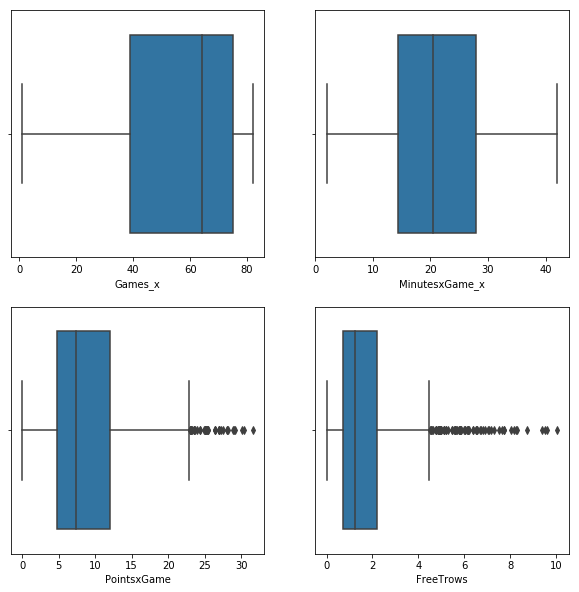

In [8]:
#Some visualizations for numerical variables
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

sn.boxplot(data['Games_x'],ax=ax1)
sn.boxplot(data['MinutesxGame_x'],ax=ax2)
sn.boxplot(data['PointsxGame'],ax=ax3)
sn.boxplot(data['FreeTrows'],ax=ax4)

plt.show()

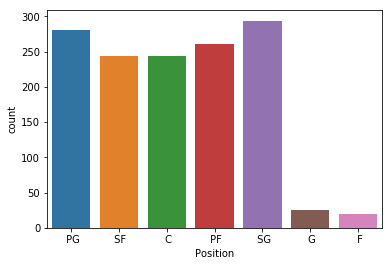

In [9]:
# players positions
# some categories dont seem to be well defined
sn.countplot(data['Position'])

In [10]:
#Dummies and merge
z = pd.get_dummies(data.Position)
frames = [data, z]
datafinal = pd.concat(frames, axis=1)
print(data.shape)

(1368, 29)


In [11]:
#Train and test data
train = datafinal[(datafinal['year'] == 2016) | (datafinal['year'] == 2017)]
test = datafinal[(datafinal['year'] == 2017)]
print(train.shape)
print(test.shape)

(946, 36)
(470, 36)


In [12]:
#selection of data
X_train = train.drop(columns=['Player', 'Team_x', 'AllStars', 'Starter', 'Position'])
y_train = train['AllStars']

X_test = test.drop(columns=['Player', 'Team_x', 'AllStars', 'Starter', 'Position'])
y_test = test['AllStars']

In [13]:
#Normalization
X_train = preprocessing.scale(X_train, axis = 0)
X_test = preprocessing.scale(X_test, axis = 0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
#Random Forest

param_trees = {'n_estimators': [100, 200],
               'max_features': [2, 5, 7, 10, 15, 20, 25],
               'max_depth': [2, 3, 4, 6, 8, 10], 
               'min_samples_leaf':[2, 5, 7, 10, 15],
               'random_state': [0]}

rf = RandomForestClassifier()
rfgrid = GridSearchCV(rf, param_grid=param_trees, cv=3, verbose=1, n_jobs=-1)
rfgrid.fit(X_train, y_train)

print(rfgrid.best_params_)
print(rfgrid.best_score_)

y_pred = rfgrid.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 392 candidates, totalling 1960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.3min


{'max_depth': 2, 'max_features': 10, 'min_samples_leaf': 10, 'n_estimators': 100, 'random_state': 0}
0.959830866807611
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       445
         1.0       0.79      0.76      0.78        25

   micro avg       0.98      0.98      0.98       470
   macro avg       0.89      0.87      0.88       470
weighted avg       0.98      0.98      0.98       470



[Parallel(n_jobs=-1)]: Done 1960 out of 1960 | elapsed:  4.8min finished


In [16]:
#Gradient Booster

param_bost = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.1, 0.3, 0.5],
               'max_features': [2, 5, 7, 10, 15, 20, 25, 30],
               'max_depth': [2, 3, 4, 6, 8, 10], 
               'min_samples_leaf':[2, 5, 7, 10, 15],
               'random_state': [0]}

gb = GradientBoostingClassifier()
gbgrid = GridSearchCV(gb, param_grid=param_bost, cv=3, verbose=1, n_jobs=-1)
gbgrid.fit(X_train, y_train)

print(gbgrid.best_params_)
print(gbgrid.best_score_)

y_pred = gbgrid.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 840 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 203 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 653 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 1029 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 1379 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1829 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2379 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed:  1.7min finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 0.1, 'max_depth': 6, 'max_features': 25, 'min_samples_leaf': 10, 'n_estimators': 100, 'random_state': 0}
0.9651162790697675
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       445
         1.0       1.00      0.92      0.96        25

   micro avg       1.00      1.00      1.00       470
   macro avg       1.00      0.96      0.98       470
weighted avg       1.00      1.00      1.00       470



In [21]:
#xgb

param_xgb = {'eta': [0.1, 0.3, 0.5],
             'max_depth': [2, 3, 4, 6, 8],
             'n_estimators': [100, 200, 300, 600],
             'min_child_weight': [1, 5, 10],
             'colsample_bytree': [0.6, 0.8, 1.0]}

xgb = XGBClassifier()
xgbgrid = GridSearchCV(xgb, param_grid=param_xgb, cv=3, verbose=1, n_jobs=-1)
xgbgrid.fit(X_train, y_train)

print(xgbgrid.best_params_)
print(xgbgrid.best_score_)

y_pred = xgbgrid.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 4860 candidates, totalling 14580 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 4876 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 6376 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 8076 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 9976 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 12076 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 14376 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 14580 out of 14580 | elapsed: 10.7min finished


{'colsample_bytree': 0.8, 'eta': 0.1, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}
0.9661733615221987
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       445
         1.0       0.92      0.88      0.90        25

   micro avg       0.99      0.99      0.99       470
   macro avg       0.95      0.94      0.95       470
weighted avg       0.99      0.99      0.99       470



In [25]:
#Voting for xgb and gradient booster models
vote = VotingClassifier(estimators=[('xgb', xgbgrid), ('gb', gbgrid)],voting='soft')
vote.fit(X_train, y_train)

y_pred_vote = vote.predict(X_test)
print(classification_report(y_test, y_pred_vote))

Fitting 3 folds for each of 4860 candidates, totalling 14580 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 814 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 1514 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2414 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3514 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 4814 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 6314 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 8014 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 9914 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 12014 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 14314 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 14580 out of 14580 | elapsed: 10.8min finished


Fitting 3 folds for each of 840 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed:  1.7min finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       445
         1.0       1.00      0.96      0.98        25

   micro avg       1.00      1.00      1.00       470
   macro avg       1.00      0.98      0.99       470
weighted avg       1.00      1.00      1.00       470



Voting with both models seems to increse both recall and f1. This last model reruns the training procces.